<a href="https://colab.research.google.com/github/Viroslav/CV/blob/main/seminar_1_preprocessing_morphology_rules_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.Install packages

In [1]:
!pip install boilerpy3
!pip install wikiextractor
!pip install yargy
!pip install ipymarkup
!pip install natasha
!pip install razdel
!pip install marisa_trie
!pip install pymorphy2
!pip install pymystem3==0.1.10 #install this specific package for demnstration in colab
!pip install transformers

!wget http://panchenko.me/data/russe/rdt/10k.txt.gz 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 2.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 117 kB/s 
     |████████████████████████████████| 55 kB 4.2 MB/s 
     |████████████████████████████████| 8.2 MB 11.4 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=2c574102da3482a8e3732554a34f2d5adf43168a7b36b48ed659c8b845c03a95
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=261


# 1.Text normalization

## 1.1. HTML-removal

### 1.1.1 BeautifulSoup



#### 1.1.1.1 Basic concepts

Let's learn how to get text from [this web page](https://en.wikisource.org/wiki/Moral_letters_to_Lucilius) for your NLP tasks

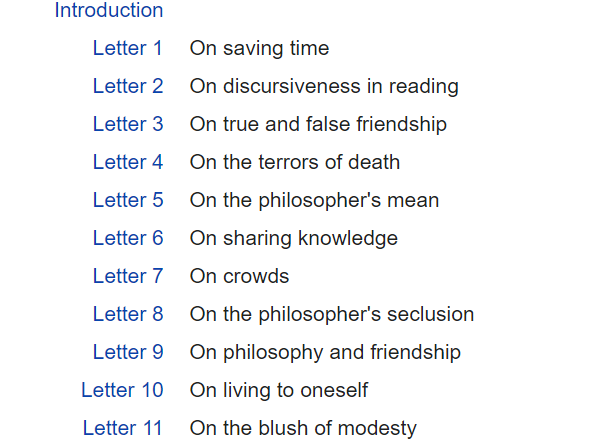

In [2]:
import requests

url = 'https://en.wikisource.org/wiki/Moral_letters_to_Lucilius'
res = requests.get(url)
html_page = res.content

In [3]:
html_page[0:5000]

b'<!DOCTYPE html>\n<html class="client-nojs" lang="en" dir="ltr">\n<head>\n<meta charset="UTF-8"/>\n<title>Moral letters to Lucilius - Wikisource, the free online library</title>\n<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":false,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"d11a647a-4492-4eb7-9753-0a0dcd8f4b34","wgCSPNonce":false,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"Moral_letters_to_Lucilius","wgTitle":"Moral letters to Lucilius","wgCurRevisionId":11180968,"wgRevisionId":11180968,"wgArticleId":482782,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["PD-old-50-US","Ancient Roman philosophical works","Works originally in Latin"],"wgPageCon

In [4]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(html_page, 'html.parser')

In [5]:
print(soup.prettify()[0:10000])

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   Moral letters to Lucilius - Wikisource, the free online library
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":false,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"d11a647a-4492-4eb7-9753-0a0dcd8f4b34","wgCSPNonce":false,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"Moral_letters_to_Lucilius","wgTitle":"Moral letters to Lucilius","wgCurRevisionId":11180968,"wgRevisionId":11180968,"wgArticleId":482782,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["PD-old-50-US","Ancient Roman philosophical works","Works originally in Latin"]

In [6]:
#Bruteforce extraction
text = soup.find_all(text=True)

In [7]:
text[:10]

['html',
 '\n',
 '\n',
 '\n',
 '\n',
 'Moral letters to Lucilius - Wikisource, the free online library',
 '\n',
 'document.documentElement.className="client-js";RLCONF={"wgBreakFrames":false,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"d11a647a-4492-4eb7-9753-0a0dcd8f4b34","wgCSPNonce":false,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"Moral_letters_to_Lucilius","wgTitle":"Moral letters to Lucilius","wgCurRevisionId":11180968,"wgRevisionId":11180968,"wgArticleId":482782,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["PD-old-50-US","Ancient Roman philosophical works","Works originally in Latin"],"wgPageContentLanguage":"en","wgPageContentModel":"wikitext","wgRelevantPageName":"M

We can see that there is much unnecessary stuf in the extratced text. We can filter it using the information about the field where the text is referred to.

There are many heuristics how o extratct sensible information from html. We will discuss some of them.


#### 1.1.1.2.Look for necessary tags inside raw html

We can inspect this manually by looking through the raw html page and using CTRL+F with some necessary text

For example one of the necessary strings "On saving time" is located in the following html:

`<td style="text-align:left;vertical-align:top;">\n          On saving time\n         </td>\n `

In [8]:
text_td = [element.text for element in soup.find_all('td')]
text_td[:20]

["\xa0SENECA\n\xa0AD LUCILIUM\n\xa0EPISTULAE MORALES\n\nWITH AN ENGLISH TRANSLATION BY\nRICHARD M. GUMMERE, PH.D.\nOF HAVERFORD COLLEGE\nIN THREE VOLUMES\n\n\n\n\nLONDON\xa0: WILLIAM HEINEMANN\nNEW YORK\xa0: G. P. PUTNAM'S SONS\n\n",
 'Introduction\n',
 '\n',
 'Letter  1\n',
 'On saving time\n',
 'Letter  2\n',
 'On discursiveness in reading\n',
 'Letter  3\n',
 'On true and false friendship\n',
 'Letter  4\n',
 'On the terrors of death\n',
 'Letter  5\n',
 "On the philosopher's mean\n",
 'Letter  6\n',
 'On sharing knowledge\n',
 'Letter  7\n',
 'On crowds\n',
 'Letter  8\n',
 "On the philosopher's seclusion\n",
 'Letter  9\n']

In [9]:
text_td = [element.text for element in soup.find_all('td', attrs = {'style':"text-align:left;vertical-align:top;"})]
text_td[:20]

['\n',
 'On saving time\n',
 'On discursiveness in reading\n',
 'On true and false friendship\n',
 'On the terrors of death\n',
 "On the philosopher's mean\n",
 'On sharing knowledge\n',
 'On crowds\n',
 "On the philosopher's seclusion\n",
 'On philosophy and friendship\n',
 'On living to oneself\n',
 'On the blush of modesty\n',
 'On old age\n',
 'On groundless fears\n',
 'On the reasons for withdrawing from the world\n',
 'On brawn and brains\n',
 'On philosophy, the guide of life\n',
 'On philosophy and riches\n',
 'On festivals and fasting\n',
 'On worldliness and retirement\n']

### 1.1.2.Boilerpipe

In [10]:
from boilerpy3 import extractors

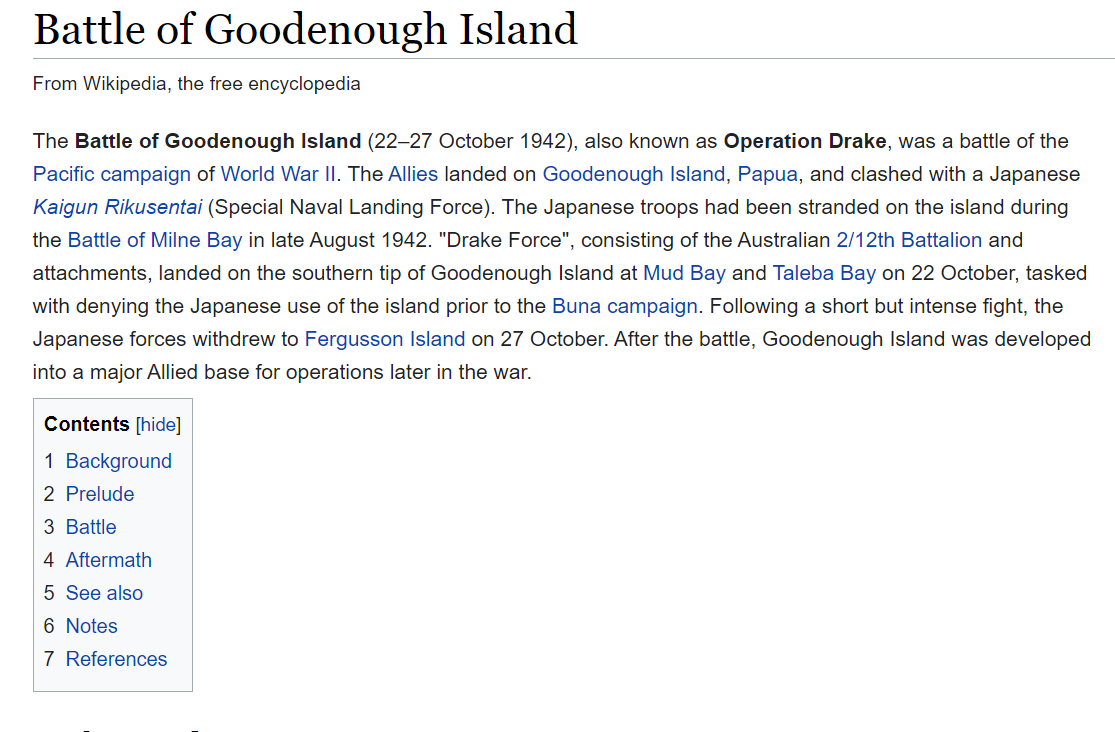

In [ ]:
url = 'https://en.wikipedia.org/wiki/Battle_of_Goodenough_Island'
extractor = extractors.ArticleExtractor()
content = extractor.get_content_from_url(url)
print(content)

Pacific battle of World War II
Battle of Goodenough Island
Australian soldiers with a Japanese flag captured during the fighting at Goodenough Island
Date
353 initially,285 during ground fighting
Casualties and losses
Location within Papua New Guinea
Show map of Papua New Guinea
Battle of Goodenough Island (Pacific Ocean)
Show map of Pacific Ocean
Western New Guinea
The Battle of Goodenough Island (22–27 October 1942), also known as Operation Drake, was a battle of the Pacific campaign of World War II . The Allies landed on Goodenough Island , Papua , and clashed with a Japanese Kaigun Rikusentai (Special Naval Landing Force). The Japanese troops had been stranded on the island during the Battle of Milne Bay in late August 1942. "Drake Force", consisting of the Australian 2/12th Battalion and attachments, landed on the southern tip of Goodenough Island at Mud Bay and Taleba Bay on 22 October, tasked with denying the Japanese use of the island prior to the Buna campaign . Following a sh

**ArticleExtractor**

A full-text extractor which is tuned towards news articles. In this scenario it achieves higher accuracy than DefaultExtractor. Works very well for most types of Article-like HTML.

In [11]:
url = 'https://en.wikisource.org/wiki/Moral_letters_to_Lucilius'
extractor = extractors.ArticleExtractor()
content = extractor.get_content_from_url(url)
print(content)

Subject index
This work is in the public domain in the United States because it was published before January 1, 1927.
The author died in 1969, so this work is in the public domain in countries and areas where the copyright term is the author's life plus 52 years or less. This work may be in the public domain in countries and areas with longer native copyright terms that apply the rule of the shorter term to foreign works.
Public domainPublic domainfalsefalse



**KeepEverythingExtractor**

Dummy extractor which marks everything as content. 


In [ ]:
url = 'https://en.wikisource.org/wiki/Moral_letters_to_Lucilius'
extractor = extractors.KeepEverythingExtractor()
content = extractor.get_content_from_url(url)
print(content)

Download
Moral letters to Lucilius
From Wikisource
Jump to navigation Jump to search
Moral letters to Lucilius (Epistulae morales ad Lucilium) by Seneca , translated by Richard Mott Gummere
sister projects : Wikipedia article , Commons category , Wikidata item .
A Loeb Classical Library edition; volume 1 published 1917; volume 2 published 1920; volume 3 published 1925
482782Moral letters to Lucilius (Epistulae morales ad Lucilium)Richard Mott GummereSeneca
SENECA
AD LUCILIUM EPISTULAE MORALES
WITH AN ENGLISH TRANSLATION BY RICHARD M. GUMMERE, PH.D. OF HAVERFORD COLLEGE
IN THREE VOLUMES
LONDON : WILLIAM HEINEMANN NEW YORK : G. P. PUTNAM'S SONS
CONTENTS
Volume 1
Introduction
Letter  1
On saving time
Letter  2
On discursiveness in reading
Letter  3
On true and false friendship
Letter  4
On the terrors of death
Letter  5
On the philosopher's mean
Letter  6
On sharing knowledge
Letter  7
On crowds
Letter  8
On the philosopher's seclusion
Letter  9
On philosophy and friendship
Letter 10
On l

Learn more about the package [here](https://pypi.org/project/boilerpy3/)

Use BeautifulSoup if you have one source with much information in it and the structure of webpages is quite similar to each other or if it is crucial to kepp the structure of text (for example question and answer or quote and reply)

If you have to parse many webpaged from different sources with extremely different html-structure it will be better to use boilerpipe.

## 1.2.1 Stopwords removal (using NLTK, spacy etc.)

In natural language processing, useless words are referred to as stop words.

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
print(stopwords.words('english'))#PRONOUNS, AUXILARY VERBS ETC.

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [ ]:
from nltk.tokenize import word_tokenize 

example_sent = "This is a sample sentence, showing off the stop words filtration."
  
word_tokens = word_tokenize(example_sent) 
print(word_tokens)

['This', 'is', 'a', 'sample', 'sentence', ',', 'showing', 'off', 'the', 'stop', 'words', 'filtration', '.']


In [ ]:
stop_words = set(stopwords.words('english')) 

filtered_sentence = [w for w in word_tokens if not w in stop_words]

print(filtered_sentence)

['This', 'sample', 'sentence', ',', 'showing', 'stop', 'words', 'filtration', '.']


## 1.3.1.Regular Expressions

### 1.3.1.0.Introduction

In [ ]:
import re

A regular expression (shortened as regex or regexp) is a sequence of characters that specifies a search pattern in text. Usually such patterns are used by string-searching algorithms for "find" or "find and replace" operations on strings.

### 1.3.1.1.Basic syntax of regular expressions

**Brackets** [...]
disjunction of characters


In [ ]:
re.findall('[Hh]ello','Hello hello good bye hhhhhello')

['Hello', 'hello', 'hello']

In [ ]:
re.findall('[abc]','a b c d')

['a', 'b', 'c']

In [ ]:
re.findall('[1234567890]','a 1 2 9')

['1', '2', '9']

**dash -** range of symbols

In [ ]:
re.findall('[0-9]','12 years old')

['1', '2']

In [ ]:
re.findall('[A-Z]','Washnigton D.C.')

['W', 'D', 'C']

In [ ]:
re.findall('[a-z]','Washnigton D.C.')

['a', 's', 'h', 'n', 'i', 'g', 't', 'o', 'n']

In [ ]:
re.findall('[a-zA-Z]','Washnigton D.C.')

['W', 'a', 's', 'h', 'n', 'i', 'g', 't', 'o', 'n', 'D', 'C']

**\d** - any decimal digit

**\D**- not a decimal digit, this is the opposite of \d

In [ ]:
re.findall('\d','11 years old')

['1', '1']

In [ ]:
re.findall('\D','11 years old')

[' ', 'y', 'e', 'a', 'r', 's', ' ', 'o', 'l', 'd']

**\s** - whitespace characters (which includes [ \t\n\r\f\v])

**\S** - not a  whitespace characters, this is the opposite of \s

In [ ]:
re.findall('\s' ,'11 years old \t Older than you!')

[' ', ' ', ' ', '\t', ' ', ' ', ' ']

In [ ]:
re.findall('\S' ,'11 years old \t Older than you!')

['1',
 '1',
 'y',
 'e',
 'a',
 'r',
 's',
 'o',
 'l',
 'd',
 'O',
 'l',
 'd',
 'e',
 'r',
 't',
 'h',
 'a',
 'n',
 'y',
 'o',
 'u',
 '!']

**\w** - Unicode word characters, numbers and the underscore

**\W** - opposite to \w

In [ ]:
re.findall('\w' ,"I'm 11 years old!")

['I', 'm', '1', '1', 'y', 'e', 'a', 'r', 's', 'o', 'l', 'd']

In [ ]:
re.findall('\W' ,"I'm 11 years old!")

["'", ' ', ' ', ' ', '!']

**caret ^** - negation

In [ ]:
re.findall('[^A-Z]','Washnigton D.C.')

['a', 's', 'h', 'n', 'i', 'g', 't', 'o', 'n', ' ', '.', '.']

In [ ]:
re.findall('[^Was]','Washnigton D.C.')

['h', 'n', 'i', 'g', 't', 'o', 'n', ' ', 'D', '.', 'C', '.']

**question mark ?** optionality of the previous expression

In [ ]:
re.findall('colou?r','colour color')

['colour', 'color']


 \* 0 or more of a previous character
 
 \+ 1 or more of a previous character

In [ ]:
re.findall('o*h!','h! oh!, ooh!, ooooh!')

['h!', 'oh!', 'ooh!', 'ooooh!']

In [ ]:
re.findall('o+h!','h! oh!, ooh!, ooooh!')

['oh!', 'ooh!', 'ooooh!']

In [ ]:
re.findall('wo+w','ww wow wooow wooooooow!')

['wow', 'wooow', 'wooooooow']

### 1.3.1.2.Basic operators of regular expressions

`re.match(pattern, string):` 

Looks for the first occurence of the pattern and return indexes of matched characters if any


*    **pattern** - what to find
*    **string** - where to find

In [ ]:
result = re.match('AV', 'AV Analytics Vidhya AV')
print (result)

<re.Match object; span=(0, 2), match='AV'>


In [ ]:
result.group(0)

'AV'

In [ ]:
result.start(), result.end()

(0, 2)

`re.search(pattern, string)`: 

Looks for the first occurence of the pattern and return matched string

In [ ]:
result = re.search('AV', 'AV Analytics Vidhya AV')
print (result)

<re.Match object; span=(0, 2), match='AV'>


In [ ]:
result.start(), result.end()

(0, 2)

In [ ]:
result.group(0)

'AV'

**re.match()** searches **only in the first line of the string** and return match object if found, else return none.

**re.search()** searches within the whole text

In [ ]:
Substring ='string'
String ='''We are learning regex with geeksforgeeks  
         regex is very useful for String matching. 
          It is fast too.'''

In [ ]:
# Use of re.match() Method 
print(re.match(Substring, String, re.IGNORECASE)) 

None


In [ ]:
# Use of re.search() Method 
print(re.search(Substring, String, re.IGNORECASE)) 

<re.Match object; span=(77, 83), match='String'>


`re.findall(pattern, string):`

Looks for all occurences of the pattern and return the list of matches

In [ ]:
result = re.findall('AV', 'AV Analytics Vidhya AV')
print(result)

['AV', 'AV']


`re.split(pattern, string, [maxsplit=0]):`

Split the string by the pattern no more than maxsplit time or as many time as possible if maxsplit equals 0

In [ ]:
result = re.split(',', 'Hello, my dear, hello!')
print (result)

['Hello', ' my dear', ' hello!']


In [ ]:
result = re.split(',', 'Hello, my dear, hello!', maxsplit = 1)
print (result)

['Hello', ' my dear, hello!']


`re.sub(pattern, repl, string):`


Looks trhough the *string*, find the *pattern* and change it with the *repl* pattern

In [ ]:
#Can be useful in depersonilizing text data
sample_text = "Her number is +71231231212, go find and kill her!!!"
re.sub('\+\d+', 'phone_number', sample_text)

'Her number is phone_number, go find and kill her!!!'

# 2.Tokenization and sentence split


Tokenization is essentially splitting a phrase, sentence, paragraph, or an entire text document into smaller units, such as individual words or terms. Each of these smaller units are called tokens

## 2.1.Standard tokenization packages

Let's try to tokenize the following string

In [ ]:
string_to_tokeinze = "А.Б. Иванов Служит в фирме А.Б.В. уже 50 лет,т.е. полвека!"

There are many approachs for text tokenization. Let's look through the most common

`str.split(sep=None, maxsplit=-1)`

Return a list of the words in the string, using sep as the delimiter string. If maxsplit is given, at most maxsplit splits are done (thus, the list will have at most maxsplit+1 elements). If maxsplit is not specified or -1, then there is no limit on the number of splits (all possible splits are made)

In [ ]:
string_to_tokeinze.split()

['А.Б.',
 'Иванов',
 'Служит',
 'в',
 'фирме',
 'А.Б.В.',
 'уже',
 '50',
 'лет,т.е.',
 'полвека!']

**NLTK** is a leading platform for building Python programs to work with human language data.

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
word_tokenize(string_to_tokeinze)

['А.Б',
 '.',
 'Иванов',
 'Служит',
 'в',
 'фирме',
 'А.Б.В',
 '.',
 'уже',
 '50',
 'лет',
 ',',
 'т.е',
 '.',
 'полвека',
 '!']

**razdel** — rule-based system for Russian sentence and word tokenization. See natasha.github.io article for more info.

In [ ]:
from razdel import tokenize

In [ ]:
list(tokenize(string_to_tokeinze))[:3]

[Substring(0, 1, 'А'), Substring(1, 2, '.'), Substring(2, 3, 'Б')]

In [ ]:
[element.text for element in list(tokenize(string_to_tokeinze))]

['А',
 '.',
 'Б',
 '.',
 'Иванов',
 'Служит',
 'в',
 'фирме',
 'А',
 '.',
 'Б',
 '.',
 'В',
 '.',
 'уже',
 '50',
 'лет',
 ',',
 'т',
 '.',
 'е',
 '.',
 'полвека',
 '!']

### 2.1.2.**Word tokenzation packages analysis**

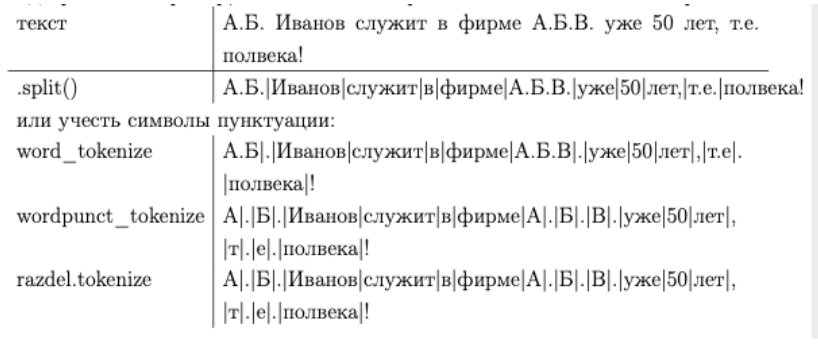

The sample has been taken from the following source: 
*Куратов Юрий Михайлович (2020). Специализация языковых моделей для применения к задачам обработки естественного языка. МФТИ. Москва*

|                         | Erorrs per 1000 tokens |Processing time, sec|
|-------------------------|------------------------|--------------------------|
| Regexp-baseline         | 19                     | 0.5                      |
| SpaCy                   | 17                     | 5.4                      |
| NLTK                    | 130                    | 3.1                      |
| MyStem                  | 19                     | 4.5                      |
| Moses                   | 11                     | 1.9                      |
| SegTok                  | 12                     | 2.1                      |
| SpaCy Russian Tokenizer | 8                      | 46.4                     |
| RuTokenizer             | 15                     | 1.0                      |
| Razdel                  | 7                      | 2.6                      |

### **2.1.2.Byte-pair-encoding**

![](https://hsto.org/getpro/habr/upload_files/3bf/fbb/379/3bffbb379f869f8ec9214b364a641277.jpeg)



A simple data compression algorithm first [introduced in 1994](https://www.derczynski.com/papers/archive/BPE_Gage.pdf). It was later reintroudiced for NLP to the task of word segmentation in [this article](https://arxiv.org/pdf/1508.07909.pdf). BPE allows for the
representation of an open vocabulary through
a fixed-size vocabulary of variable-length
character sequences, making it a very suitable word segmentation strategy for neural
network models.

In [ ]:
from transformers import GPT2Tokenizer
model_name_or_path = "sberbank-ai/rugpt3large_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_path)

In [ ]:
text = "Токенизируй меня" 
tokens = tokenizer.encode(text, add_special_tokens=False) 
decoded_tokens = [tokenizer.decode([token]) for token in tokens] 


print("text:           ", text)
print("decoded tokens: ", decoded_tokens)
print("tokens:         ", tokens)

text:            Токенизируй меня
decoded tokens:  ['Т', 'ок', 'ени', 'зи', 'руй', ' меня']
tokens:          [789, 368, 337, 848, 28306, 703]


[More examples for GPT](https://habr.com/ru/post/599673/) 

### 2.1.2.1.BPE simple version 

The code below shows a toy example of learned BPE operations. At test time, we first split words into sequences of characters, then apply the learned operations to merge the characters into larger, known symbols. This is applicable to any word, and allows for open-vocabulary networks with fixed symbol vocabularies. In our example, the ‘lower’ would be segmented into ‘low er·’

In [ ]:
# assuming we've extracted from our raw text a vocabulary along with its frequency
vocab = {
    'l o w </w>': 5,
    'l o w e r </w>': 2,
    'n e w e s t </w>': 6,
    'w i d e s t </w>': 3,
    'h a p p i e r </w>': 2
}

def get_pair_stats(vocab):
    """Get counts of pairs of consecutive symbols."""

    pairs = {}
    for word, frequency in vocab.items():
        symbols = word.split()

        # count occurrences of pairs
        for i in range(len(symbols) - 1):
            pair = (symbols[i], symbols[i + 1])
            current_frequency = pairs.get(pair, 0)
            pairs[pair] = current_frequency + frequency

    return pairs



In [ ]:
pair_stats = get_pair_stats(vocab)
pair_stats

{('l', 'o'): 7,
 ('o', 'w'): 7,
 ('w', '</w>'): 5,
 ('w', 'e'): 8,
 ('e', 'r'): 4,
 ('r', '</w>'): 4,
 ('n', 'e'): 6,
 ('e', 'w'): 6,
 ('e', 's'): 9,
 ('s', 't'): 9,
 ('t', '</w>'): 9,
 ('w', 'i'): 3,
 ('i', 'd'): 3,
 ('d', 'e'): 3,
 ('h', 'a'): 2,
 ('a', 'p'): 2,
 ('p', 'p'): 2,
 ('p', 'i'): 2,
 ('i', 'e'): 2}

In [ ]:
def merge_vocab(best_pair, vocab_in):
    """Step 3. Merge all occurrences of the most frequent pair"""

    vocab_out = {}

    # re.escape
    # ensures the characters of our input pair will be handled as is and
    # not get mistreated as special characters in the regular expression ([],\ etc.).
    pattern = re.escape(' '.join(best_pair))
    replacement = ''.join(best_pair)

    for word_in in vocab_in:
        # replace most frequent pair in all vocabulary
        word_out = re.sub(pattern, replacement, word_in)
        vocab_out[word_out] = vocab_in[word_in]

    return vocab_out

In [ ]:
best_pair = max(pair_stats, key=pair_stats.get)
print("best_pair:", best_pair)

new_vocab = merge_vocab(best_pair, vocab)
new_vocab

best_pair: ('e', 's')


{'l o w </w>': 5,
 'l o w e r </w>': 2,
 'n e w es t </w>': 6,
 'w i d es t </w>': 3,
 'h a p p i e r </w>': 2}

In [ ]:
vocab = {
    'l o w </w>': 5,
    'l o w e r </w>': 2,
    'n e w e s t </w>': 6,
    'w i d e s t </w>': 3,
    'h a p p i e r </w>': 2
}

# we store the best pair during each iteration for encoding new vocabulary, more on this later
bpe_codes = {}
num_merges = 10  # hyperparameter
for i in range(num_merges):
    print('\niteration', i)
    pair_stats = get_pair_stats(vocab)
    if not pair_stats:
        break

    best_pair = max(pair_stats, key=pair_stats.get)
    bpe_codes[best_pair] = i

    print('vocabulary: ', vocab)
    print('best pair:', best_pair)
    vocab = merge_vocab(best_pair, vocab)

print('\nfinal vocabulary: ', vocab)
print('\nbyte pair encoding: ', bpe_codes)


iteration 0
vocabulary:  {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w e s t </w>': 6, 'w i d e s t </w>': 3, 'h a p p i e r </w>': 2}
best pair: ('e', 's')

iteration 1
vocabulary:  {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w es t </w>': 6, 'w i d es t </w>': 3, 'h a p p i e r </w>': 2}
best pair: ('es', 't')

iteration 2
vocabulary:  {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est </w>': 6, 'w i d est </w>': 3, 'h a p p i e r </w>': 2}
best pair: ('est', '</w>')

iteration 3
vocabulary:  {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3, 'h a p p i e r </w>': 2}
best pair: ('l', 'o')

iteration 4
vocabulary:  {'lo w </w>': 5, 'lo w e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3, 'h a p p i e r </w>': 2}
best pair: ('lo', 'w')

iteration 5
vocabulary:  {'low </w>': 5, 'low e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3, 'h a p p i e r </w>': 2}
best pair: ('n', 'e')

iteration 6
vocabulary:  {'low </w>': 5, 'low e r </w>': 2, 'ne w est</w>'

In [ ]:
bpe_codes

{('e', 's'): 0,
 ('es', 't'): 1,
 ('est', '</w>'): 2,
 ('l', 'o'): 3,
 ('lo', 'w'): 4,
 ('n', 'e'): 5,
 ('ne', 'w'): 6,
 ('new', 'est</w>'): 7,
 ('low', '</w>'): 8,
 ('e', 'r'): 9}

In [ ]:
vocab

{'low</w>': 5,
 'low er </w>': 2,
 'newest</w>': 6,
 'w i d est</w>': 3,
 'h a p p i er </w>': 2}

### 2.1.2.2.BPE advanced version implementation

Let's look through more advanced implementation of byte pairs encoding algo from [here](https://github.com/soaxelbrooke/python-bpe/blob/master/bpe/encoder.py)

In [ ]:
from collections import Counter

try:
    from typing import Dict, Iterable, Callable, List, Any, Iterator
except ImportError:
    pass

from nltk.tokenize import wordpunct_tokenize
from tqdm import tqdm
import toolz
import json

DEFAULT_EOW = '__eow'
DEFAULT_SOW = '__sow'
DEFAULT_UNK = '__unk'
DEFAULT_PAD = '__pad'


class Encoder:
    """ Encodes white-space separated text using byte-pair encoding.  See https://arxiv.org/abs/1508.07909 for details.
    """

    def __init__(self, vocab_size=8192, pct_bpe=0.2, word_tokenizer=None,
                 silent=True, ngram_min=2, ngram_max=2, required_tokens=None,
                 strict=False, lowercase=True,
                 EOW=DEFAULT_EOW, SOW=DEFAULT_SOW, UNK=DEFAULT_UNK, PAD=DEFAULT_PAD):
        if vocab_size < 1:
            raise ValueError('vocab size must be greater than 0.')

        self.EOW = EOW
        self.SOW = SOW
        self.eow_len = len(EOW)
        self.sow_len = len(SOW)
        self.UNK = UNK
        self.PAD = PAD
        self.required_tokens = list(set(required_tokens or []).union({self.UNK, self.PAD}))
        self.vocab_size = vocab_size #how many unique tokens will you get in the end
        self.pct_bpe = pct_bpe #percent of words which will be decomposed into subtokens using bpe algorithm
        self.word_vocab_size = max([int(vocab_size * (1 - pct_bpe)), len(self.required_tokens or [])])#how many full-word tokens will be among final tokens
        self.bpe_vocab_size = vocab_size - self.word_vocab_size#how many bpe subtokens will be among final tokens
        self.word_tokenizer = word_tokenizer if word_tokenizer is not None else wordpunct_tokenize
        self.custom_tokenizer = word_tokenizer is not None
        self.word_vocab = {}  # type: Dict[str, int]
        self.bpe_vocab = {}  # type: Dict[str, int]
        self.inverse_word_vocab = {}  # type: Dict[int, str]
        self.inverse_bpe_vocab = {}  # type: Dict[int, str]
        self._progress_bar = iter if silent else tqdm
        self.ngram_min = ngram_min
        self.ngram_max = ngram_max
        self.strict = strict
        self.lowercase = lowercase

    def mute(self):
        """ Turn on silent mode """
        self._progress_bar = iter

    def unmute(self):
        """ Turn off silent mode """
        self._progress_bar = tqdm

    def byte_pair_counts(self, words):
        # type: (Encoder, Iterable[str]) -> Iterable[Counter]
        """ Counts space separated token character pairs:
            [('T h i s </w>', 4}] -> {'Th': 4, 'hi': 4, 'is': 4}
        """
        for token, count in self._progress_bar(self.count_tokens(words).items()):
            bp_counts = Counter()  # type: Counter
            for ngram in token.split(' '):
                bp_counts[ngram] += count#count single letter
            for ngram_size in range(self.ngram_min, min([self.ngram_max, len(token)]) + 1):#count ngramms 
                ngrams = [''.join(ngram) for ngram in toolz.sliding_window(ngram_size, token.split(' '))]
                for ngram in ngrams:
                    bp_counts[''.join(ngram)] += count
            yield bp_counts

    def count_tokens(self, words):
        # type: (Encoder, Iterable[str]) -> Dict[str, int]
        """ Count tokens into a BPE vocab """
        token_counts = Counter(self._progress_bar(words))
        return {' '.join(token): count for token, count in token_counts.items()}

    def learn_word_vocab(self, sentences):
        # type: (Encoder, Iterable[str]) -> Dict[str, int]
        """ Build vocab from self.word_vocab_size most common tokens in provided sentences """
        word_counts = Counter(word for word in toolz.concat(map(self.word_tokenizer, sentences)))#tokenize words and count occurencies in text
        for token in set(self.required_tokens or []):
            word_counts[token] = int(2**63)#set nrequired tokens frequency to big value so thewy will be in the beginning og the sorted frequencies dict    
        sorted_word_counts = sorted(word_counts.items(), key=lambda p: -p[1])#sort word frequency dict 
        return {word: idx for idx, (word, count) in enumerate(sorted_word_counts[:self.word_vocab_size])} 

    def learn_bpe_vocab(self, words):
        # type: (Encoder, Iterable[str]) -> Dict[str, int]
        """ Learns a vocab of byte pair encodings """
        vocab = Counter()  # type: Counter
        for token in {self.SOW, self.EOW}:
            vocab[token] = int(2**63)
        for idx, byte_pair_count in enumerate(self.byte_pair_counts(words)):#extract ngrams with size from ngram_min to ngram_max
            for byte_pair, count in byte_pair_count.items():
                vocab[byte_pair] += count

            if (idx + 1) % 10000 == 0:
                self.trim_vocab(10 * self.bpe_vocab_size, vocab)#delete rare pairs in case of big pairs quantity
        #sort subtokens dict by frequency and return the number of tokens equals to self.bpe_vocab_size
        sorted_bpe_counts = sorted(vocab.items(), key=lambda p: -p[1])[:self.bpe_vocab_size]
        return {bp: idx + self.word_vocab_size for idx, (bp, count) in enumerate(sorted_bpe_counts)}

    def fit(self, text):
        # type: (Encoder, Iterable[str]) -> None
        """ Learn vocab from text. """
        if self.lowercase:
            _text = [l.lower().strip() for l in text]
        else:
            _text = [l.strip() for l in text]
        # First, learn word vocab
        self.word_vocab = self.learn_word_vocab(_text)#get word:id dict with most frequent words from text - these words will be leaft intact in final tokens list
        remaining_words = [word for word in toolz.concat(map(self.word_tokenizer, _text))
                           if word not in self.word_vocab]#words to be processed with bpe algo
        self.bpe_vocab = self.learn_bpe_vocab(remaining_words)

        self.inverse_word_vocab = {idx: token for token, idx in self.word_vocab.items()}
        self.inverse_bpe_vocab = {idx: token for token, idx in self.bpe_vocab.items()}

    @staticmethod
    def trim_vocab(n, vocab):
        # type: (int, Dict[str, int]) -> None
        """  Deletes all pairs below 10 * vocab size to prevent memory problems """
        pair_counts = sorted(vocab.items(), key=lambda p: -p[1])
        pairs_to_trim = [pair for pair, count in pair_counts[n:]]
        for pair in pairs_to_trim:
            del vocab[pair]

    def subword_tokenize(self, word):
        # type: (Encoder, str) -> List[str]
        """ Tokenizes inside an unknown token using BPE """
        end_idx = min([len(word), self.ngram_max])
        sw_tokens = [self.SOW]
        start_idx = 0

        while start_idx < len(word):
            subword = word[start_idx:end_idx]
            if subword in self.bpe_vocab:
                sw_tokens.append(subword)
                start_idx = end_idx
                end_idx = min([len(word), start_idx + self.ngram_max])
            elif len(subword) == 1:#the word is not found 
                sw_tokens.append(self.UNK)
                start_idx = end_idx
                end_idx = min([len(word), start_idx + self.ngram_max])
            else:
                end_idx -= 1

        sw_tokens.append(self.EOW)
        return sw_tokens

    def tokenize(self, sentence):
        # type: (Encoder, str) -> List[str]
        """ Split a sentence into word and subword tokens """
        if self.lowercase:
            word_tokens = self.word_tokenizer(sentence.lower().strip())
        else:
            word_tokens = self.word_tokenizer(sentence.strip())
        tokens = []
        for word_token in word_tokens:
            if word_token in self.word_vocab:#if word token among full words tokens of Encoder then use the exact word token
                tokens.append(word_token)
            else: #otherwise compose word from bpe tokens
                tokens.extend(self.subword_tokenize(word_token))

        return tokens

    def transform(self, sentences, reverse=False, fixed_length=None):
        # type: (Encoder, Iterable[str], bool, int) -> Iterable[List[int]]
        """ Turns space separated tokens into vocab idxs """
        direction = -1 if reverse else 1
        for sentence in self._progress_bar(sentences):
            in_subword = False
            encoded = []
            if self.lowercase:
                tokens = list(self.tokenize(sentence.lower().strip()))
            else:
                tokens = list(self.tokenize(sentence.strip()))
            for token in tokens:
                if in_subword:
                    if token in self.bpe_vocab:
                        if token == self.EOW:
                            in_subword = False
                        encoded.append(self.bpe_vocab[token])
                    else:
                        encoded.append(self.word_vocab[self.UNK])
                else:
                    if token == self.SOW:
                        in_subword = True
                        encoded.append(self.bpe_vocab[token])
                    else:
                        if token in self.word_vocab:
                            encoded.append(self.word_vocab[token])
                        else:
                            encoded.append(self.word_vocab[self.UNK])

            if fixed_length is not None:
                encoded = encoded[:fixed_length]
                while len(encoded) < fixed_length:
                    encoded.append(self.word_vocab[self.PAD])

            yield encoded[::direction]

    def inverse_transform(self, rows):
        # type: (Encoder, Iterable[List[int]]) -> Iterator[str]
        """ Turns token indexes back into space-joined text. """
        for row in rows:
            words = []

            rebuilding_word = False
            current_word = ''
            for idx in row:
                if self.inverse_bpe_vocab.get(idx) == self.SOW:
                    if rebuilding_word and self.strict:
                        raise ValueError('Encountered second SOW token before EOW.')
                    rebuilding_word = True

                elif self.inverse_bpe_vocab.get(idx) == self.EOW:
                    if not rebuilding_word and self.strict:
                        raise ValueError('Encountered EOW without matching SOW.')
                    rebuilding_word = False
                    words.append(current_word)
                    current_word = ''

                elif rebuilding_word and (idx in self.inverse_bpe_vocab):
                    current_word += self.inverse_bpe_vocab[idx]

                elif rebuilding_word and (idx in self.inverse_word_vocab):
                    current_word += self.inverse_word_vocab[idx]

                elif idx in self.inverse_word_vocab:
                    words.append(self.inverse_word_vocab[idx])

                elif idx in self.inverse_bpe_vocab:
                    if self.strict:
                        raise ValueError("Found BPE index {} when not rebuilding word!".format(idx))
                    else:
                        words.append(self.inverse_bpe_vocab[idx])

                else:
                    raise ValueError("Got index {} that was not in word or BPE vocabs!".format(idx))

            yield ' '.join(w for w in words if w != '')

    def vocabs_to_dict(self, dont_warn=False):
        # type: (Encoder, bool) -> Dict[str, Dict[str, int]]
        """ Turns vocab into dict that is json-serializeable """
        if self.custom_tokenizer and not dont_warn:
            print("WARNING! You've specified a non-default tokenizer.  You'll need to reassign it when you load the "
                  "model!")
        return {
            'byte_pairs': self.bpe_vocab,
            'words': self.word_vocab,
            'kwargs': {
                'vocab_size': self.vocab_size,
                'pct_bpe': self.pct_bpe,
                'silent': self._progress_bar is iter,
                'ngram_min': self.ngram_min,
                'ngram_max': self.ngram_max,
                'required_tokens': self.required_tokens,
                'strict': self.strict,
                'EOW': self.EOW,
                'SOW': self.SOW,
                'UNK': self.UNK,
                'PAD': self.PAD,
            }
        }

    def save(self, outpath, dont_warn=False):
        # type: (Encoder, str, bool) -> None
        """ Serializes and saves encoder to provided path """
        with open(outpath, 'w') as outfile:
            json.dump(self.vocabs_to_dict(dont_warn), outfile)

    @classmethod
    def from_dict(cls, vocabs):
        # type: (Any, Dict[str, Dict[str, int]]) -> Encoder
        """ Load encoder from dict produced with vocabs_to_dict """
        encoder = Encoder(**vocabs['kwargs'])
        encoder.word_vocab = vocabs['words']
        encoder.bpe_vocab = vocabs['byte_pairs']

        encoder.inverse_bpe_vocab = {v: k for k, v in encoder.bpe_vocab.items()}
        encoder.inverse_word_vocab = {v: k for k, v in encoder.word_vocab.items()}

        return encoder

    @classmethod
    def load(cls, in_path):
        # type: (Any, str) -> Encoder
        """ Loads an encoder from path saved with save """
        with open(in_path) as infile:
            obj = json.load(infile)
        return cls.from_dict(obj)

1


### 2.1.2.3.BPE advanced version inference

In [ ]:
test_corpus = '''
    Object raspberrypi functools dict kwargs. Gevent raspberrypi functools. Dunder raspberrypi decorator dict didn't lambda zip import pyramid, she lambda iterate?
    Kwargs raspberrypi diversity unit object gevent. Import fall integration decorator unit django yield functools twisted. Dunder integration decorator he she future. Python raspberrypi community pypy. Kwargs integration beautiful test reduce gil python closure. Gevent he integration generator fall test kwargs raise didn't visor he itertools...
    Reduce integration coroutine bdfl he python. Cython didn't integration while beautiful list python didn't nit!
    Object fall diversity 2to3 dunder script. Python fall for: integration exception dict kwargs dunder pycon. Import raspberrypi beautiful test import six web. Future integration mercurial self script web. Return raspberrypi community test she stable.
    Django raspberrypi mercurial unit import yield raspberrypi visual rocksdahouse. Dunder raspberrypi mercurial list reduce class test scipy helmet zip?
'''

encoder = Encoder(200, pct_bpe=0.75)
encoder.fit(test_corpus.split('\n'))

In [ ]:
list(encoder.word_vocab.items())[:10]

[('__unk', 0),
 ('__pad', 1),
 ('.', 2),
 ('raspberrypi', 3),
 ('integration', 4),
 ('kwargs', 5),
 ('dunder', 6),
 ('import', 7),
 ('python', 8),
 ('test', 9)]

In [ ]:
list(encoder.bpe_vocab.items())[:30]

[('__eow', 50),
 ('__sow', 51),
 ('e', 52),
 ('s', 53),
 ('t', 54),
 ('o', 55),
 ('c', 56),
 ('i', 57),
 ('l', 58),
 ('n', 59),
 ('h', 60),
 ('r', 61),
 ('a', 62),
 ('y', 63),
 ('on', 64),
 ('p', 65),
 ('u', 66),
 ('ho', 67),
 ('le', 68),
 ('f', 69),
 ('x', 70),
 ('py', 71),
 ('se', 72),
 ('el', 73),
 ('et', 74),
 ('cy', 75),
 ('yt', 76),
 ('th', 77),
 ('w', 78),
 ('wh', 79)]

In [ ]:
example = "Vizzini: He didn't fall? INCONCEIVABLE!"
print(encoder.tokenize(example))

['__sow', 'vi', '__unk', '__unk', 'i', 'ni', '__eow', '__sow', ':', '__eow', 'he', 'didn', "'", 't', 'fall', '?', '__sow', 'i', 'n', 'co', 'n', 'ce', 'i', 'v', 'ab', 'le', '__eow', '__sow', '!', '__eow']


In [ ]:
print(next(encoder.transform([example])))

[50, 115, 1, 1, 57, 82, 51, 50, 92, 51, 14, 10, 11, 12, 13, 27, 50, 57, 59, 101, 59, 95, 57, 114, 112, 68, 51, 50, 84, 51]


In [ ]:
print(next(encoder.inverse_transform(encoder.transform([example]))))

vi__unk__unkini : he didn ' t fall ? inconceivable !


## 2.2.Sentence split

**3.2.1.Sentence split packages**

In [ ]:
text = '''
... - "Так в чем же дело?" - "Не ра-ду-ют".
... И т. д. и т. п. В общем, вся газета
... '''

In [ ]:
re.split('[.!?]',text)

['\n- "Так в чем же дело',
 '" - "Не ра-ду-ют"',
 '\nИ т',
 ' д',
 ' и т',
 ' п',
 ' В общем, вся газета\n']

In [ ]:
from razdel import sentenize

In [ ]:
list(sentenize(text))

[Substring(1, 23, '- "Так в чем же дело?"'),
 Substring(24, 40, '- "Не ра-ду-ют".'),
 Substring(41, 56, 'И т. д. и т. п.'),
 Substring(57, 76, 'В общем, вся газета')]

**3.2.2.Sentence split packages analysis**

| | Erorrs per 1000 sentences |Processing time, sec|
|----------------------------|--------------------------|------|
| Regexp-baseline            | 76                       | 0.7  |
| SegTok                     | 381                      | 10.8 |
| Moses                      | 166                      | 7.0  |
| NLTK                       | 57                       | 7.1  |
| DeepPavlov                 | 41                       | 8.5  |
| Razdel                     | 43                       | 4.8  |

# 3.Lemmatization 

Lemmatization usually aims to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma, with the use of a vocabulary and morphological analysis of words

## 3.1.NLTK

In [ ]:
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
lemmatizer.lemmatize('looked', pos = wordnet.VERB)

'look'

In [ ]:
lemmatizer.lemmatize('looked')

'looked'

In [ ]:
lemmatizer.lemmatize('tries')#better but not always crucial

'try'

In [ ]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatization(string):
    word_list = word_tokenize(string)
    pos_tagged_ngramm = pos_tag(word_list)
    list_with_lemmas = []
    for word, pos_i in pos_tagged_ngramm:
        pos = get_wordnet_pos(pos_i)
        if pos is not None:
            lemma = lemmatizer.lemmatize(word, pos =pos)
        else:
            lemma = lemmatizer.lemmatize(word)
        list_with_lemmas.append(lemma)
    return list_with_lemmas
    
txt = "Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item"
lemmatization(txt)

['Lemmatization',
 'be',
 'the',
 'process',
 'of',
 'group',
 'together',
 'the',
 'different',
 'inflected',
 'form',
 'of',
 'a',
 'word',
 'so',
 'they',
 'can',
 'be',
 'analyse',
 'a',
 'a',
 'single',
 'item']

## 3.2.pymorphy2

Python library for text proessing. It uses http://opencorpora.org/ for dictionary words and creates morpgological hypothesis for out-of0dictionary words.

In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [ ]:
morph.parse('бутявкоедами')

[Parse(word='бутявкоедами', tag=OpencorporaTag('NOUN,anim,masc plur,ablt'), normal_form='бутявкоед', score=0.9821428571428571, methods_stack=((FakeDictionary(), 'бутявкоедами', 52, 10), (KnownSuffixAnalyzer(min_word_length=4, score_multiplier=0.5), 'едами'))),
 Parse(word='бутявкоёдами', tag=OpencorporaTag('NOUN,anim,masc,Name plur,ablt'), normal_form='бутявкоёд', score=0.008928571428571428, methods_stack=((FakeDictionary(), 'бутявкоёдами', 27, 10), (KnownSuffixAnalyzer(min_word_length=4, score_multiplier=0.5), 'ёдами'))),
 Parse(word='бутявкоёдами', tag=OpencorporaTag('NOUN,inan,masc plur,ablt'), normal_form='бутявкоёд', score=0.008928571428571428, methods_stack=((FakeDictionary(), 'бутявкоёдами', 34, 10), (KnownSuffixAnalyzer(min_word_length=4, score_multiplier=0.5), 'ёдами')))]

In [ ]:
morph.parse('стали')

[Parse(word='стали', tag=OpencorporaTag('VERB,perf,intr plur,past,indc'), normal_form='стать', score=0.975342, methods_stack=((DictionaryAnalyzer(), 'стали', 945, 4),)),
 Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn sing,gent'), normal_form='сталь', score=0.010958, methods_stack=((DictionaryAnalyzer(), 'стали', 13, 1),)),
 Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn plur,nomn'), normal_form='сталь', score=0.005479, methods_stack=((DictionaryAnalyzer(), 'стали', 13, 6),)),
 Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn sing,datv'), normal_form='сталь', score=0.002739, methods_stack=((DictionaryAnalyzer(), 'стали', 13, 2),)),
 Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn sing,loct'), normal_form='сталь', score=0.002739, methods_stack=((DictionaryAnalyzer(), 'стали', 13, 5),)),
 Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn plur,accs'), normal_form='сталь', score=0.002739, methods_stack=((DictionaryAnalyzer(), 'стали', 13, 9),))]

In [ ]:
morph.parse('стали')[0].normal_form

'стать'

## 3.3.pymystem3

A Python wrapper of the Yandex Mystem 3.1 morphological analyzer (http://api.yandex.ru/mystem). The original tool is shipped as a binary and this library makes it easy to integrate it in Python projects. 

In [ ]:
from pymystem3 import Mystem
m = Mystem()

In [ ]:
text = "Красивая мама красиво мыла раму"
lemmas = m.lemmatize(text)
print(''.join(lemmas))

красивый мама красиво мыть рама



## 3.4.spacy

In [ ]:
import spacy
nlp = spacy.load('en')

In [ ]:
doc = nlp("Hello, world. Here are two sentences.")
print([t.lemma_ for t in doc])

['hello', ',', 'world', '.', 'here', 'be', 'two', 'sentence', '.']


## 3.5 Natasha 

In [ ]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,
    DatesExtractor,
    MoneyExtractor,
    AddrExtractor,

    Doc
)

emb = NewsEmbedding()
segmenter = Segmenter()

morph_vocab = MorphVocab()

morph_tagger = NewsMorphTagger(emb)

syntax_parser = NewsSyntaxParser(emb)

In [ ]:
text = 'Это нейронная сеть для генерации (продолжения) текста. Если чуть подробнее и сложнее, то это — языковая модель, основанная на архитектуре трансформер и обученная в self-supervised режиме на куче текстовых данных.'
doc = Doc(text)
doc

Doc(text='Это нейронная сеть для генерации (продолжения) те...)

In [ ]:
doc.segment(segmenter)
display(doc)
display(doc.sents[:2])
display(doc.tokens[:5])

Doc(text='Это нейронная сеть для генерации (продолжения) те..., tokens=[...], sents=[...])

[DocSent(stop=54, text='Это нейронная сеть для генерации (продолжения) те..., tokens=[...]),
 DocSent(start=55, stop=212, text='Если чуть подробнее и сложнее, то это — языковая ..., tokens=[...])]

[DocToken(stop=3, text='Это'),
 DocToken(start=4, stop=13, text='нейронная'),
 DocToken(start=14, stop=18, text='сеть'),
 DocToken(start=19, stop=22, text='для'),
 DocToken(start=23, stop=32, text='генерации')]

In [ ]:
doc.tag_morph(morph_tagger)
doc.parse_syntax(syntax_parser)
display(doc.tokens[:5])

[DocToken(stop=3, text='Это', id='1_1', head_id='1_3', rel='nsubj', pos='PRON', feats=<Inan,Nom,Neut,Sing>, lemma='это'),
 DocToken(start=4, stop=13, text='нейронная', id='1_2', head_id='1_3', rel='amod', pos='ADJ', feats=<Nom,Pos,Fem,Sing>, lemma='нейронный'),
 DocToken(start=14, stop=18, text='сеть', id='1_3', head_id='1_0', rel='root', pos='NOUN', feats=<Inan,Nom,Fem,Sing>, lemma='сеть'),
 DocToken(start=19, stop=22, text='для', id='1_4', head_id='1_5', rel='case', pos='ADP', lemma='для'),
 DocToken(start=23, stop=32, text='генерации', id='1_5', head_id='1_3', rel='nmod', pos='NOUN', feats=<Inan,Gen,Fem,Sing>, lemma='генерация')]

In [ ]:
for token in doc.tokens:
    token.lemmatize(morph_vocab)

In [ ]:
{_.text: _.lemma for _ in doc.tokens[:10]}

{'Это': 'это',
 'нейронная': 'нейронный',
 'сеть': 'сеть',
 'для': 'для',
 'генерации': 'генерация',
 '(': '(',
 'продолжения': 'продолжение',
 ')': ')',
 'текста': 'текст',
 '.': '.'}

# 4.Part of speech tagging

POS Tags are useful for building parse trees, which are used in building NER task (most named entities are Nouns) and extracting relations between words. POS Tagging is also essential for building lemmatizers.

## 4.1.NLTK

In [ ]:
from nltk import pos_tag

In [ ]:
text = "Previous answer is convoluted and can't be edited"
word_list = word_tokenize(text)
pos_tagged_ngramm = pos_tag(word_list)
pos_tagged_ngramm

[('Previous', 'JJ'),
 ('answer', 'NN'),
 ('is', 'VBZ'),
 ('convoluted', 'VBN'),
 ('and', 'CC'),
 ('ca', 'MD'),
 ("n't", 'RB'),
 ('be', 'VB'),
 ('edited', 'VBN')]

## 4.2.pymorphy2

In [ ]:
morph.parse('бутявковедами')

[Parse(word='бутявковедами', tag=OpencorporaTag('NOUN,anim,masc plur,ablt'), normal_form='бутявковед', score=0.9821428571428571, methods_stack=((FakeDictionary(), 'бутявковедами', 52, 10), (KnownSuffixAnalyzer(min_word_length=4, score_multiplier=0.5), 'едами'))),
 Parse(word='бутявковёдами', tag=OpencorporaTag('NOUN,anim,masc,Name plur,ablt'), normal_form='бутявковёд', score=0.008928571428571428, methods_stack=((FakeDictionary(), 'бутявковёдами', 27, 10), (KnownSuffixAnalyzer(min_word_length=4, score_multiplier=0.5), 'ёдами'))),
 Parse(word='бутявковёдами', tag=OpencorporaTag('NOUN,inan,masc plur,ablt'), normal_form='бутявковёд', score=0.008928571428571428, methods_stack=((FakeDictionary(), 'бутявковёдами', 34, 10), (KnownSuffixAnalyzer(min_word_length=4, score_multiplier=0.5), 'ёдами')))]

In [ ]:
morph.parse('бутявковедами')[0].tag.POS

'NOUN'

In [ ]:
p = morph.parse('бутявковедами')[0]
p.tag.animacy, p.tag.number 

('anim', 'plur')

More information about other features of pymorphy can be found [here](https://pymorphy2.readthedocs.io/en/0.2/user/index.html) 

## 4.3.pymystem3

In [ ]:
import json
from pymystem3 import Mystem

In [ ]:
m = Mystem()

In [ ]:
text = "Красивая мама красиво мыла раму"

In [ ]:
parsed_text = m.analyze(text)

In [ ]:
parsed_text

[{'analysis': [{'gr': 'A=им,ед,полн,жен', 'lex': 'красивый', 'wt': 1}],
  'text': 'Красивая'},
 {'text': ' '},
 {'analysis': [{'gr': 'S,жен,од=им,ед', 'lex': 'мама', 'wt': 1}],
  'text': 'мама'},
 {'text': ' '},
 {'analysis': [{'gr': 'ADV=', 'lex': 'красиво', 'wt': 0.8149252534}],
  'text': 'красиво'},
 {'text': ' '},
 {'analysis': [{'gr': 'V,несов,пе=прош,ед,изъяв,жен',
    'lex': 'мыть',
    'wt': 0.4415209889}],
  'text': 'мыла'},
 {'text': ' '},
 {'analysis': [{'gr': 'S,жен,неод=вин,ед', 'lex': 'рама', 'wt': 0.9993591309}],
  'text': 'раму'},
 {'text': '\n'}]

In [ ]:
parsed_text[0]['analysis'][0]

{'gr': 'A=им,ед,полн,жен', 'lex': 'красивый', 'wt': 1}

## 4.4.spacy

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc_spacy = nlp("Apple is looking at buying U.K. startup for $1 billion")

for token in doc_spacy:
    print(token.text, token.pos_)
    # print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
    #         token.shape_, token.is_alpha, token.is_stop)

Apple PROPN
is AUX
looking VERB
at ADP
buying VERB
U.K. PROPN
startup NOUN
for ADP
$ SYM
1 NUM
billion NUM


## 4.5 Natasha

When we applied segmenter, morph_tagger and syntax_parser to the article text Natasha assigned POS-tags alongside ith other information. Now we can just have a look at it

In [ ]:
for token in doc.tokens[:10]:
  print(token.text, token.pos)

Посол NOUN
Израиля PROPN
на ADP
Украине PROPN
Йоэль PROPN
Лион PROPN
признался VERB
, PUNCT
что SCONJ
пришел VERB


# 5.Named entity recognition

Named entity is a real-world object, such as persons, locations, organizations, products, etc., that can be denoted with a proper name. It can be abstract or have a physical existence. Examples of named entities include Barack Obama, New York City, Volkswagen Golf, or anything else that can be named

## 5.1.Spacy

In [ ]:
import spacy

In [ ]:
text = ("When Sebastian Thrun started working on self-driving cars at "
        "Google in 2007, few people outside of the company took him "
        "seriously. “I can tell you very senior CEOs of major American "
        "car companies would shake my hand and turn away because I wasn’t "
        "worth talking to,” said Thrun, in an interview with Recode earlier "
        "this week.")

In [ ]:
nlp = spacy.load("en_core_web_sm")
doc_spacy = nlp(text)

In [ ]:
for entity in doc_spacy.ents:
    print(entity.text, entity.label_)

Sebastian NORP
Google ORG
2007 DATE
American NORP
Recode ORG
earlier this week DATE


In [ ]:
print("Noun phrases:", [chunk.text for chunk in doc_spacy.noun_chunks])

Noun phrases: ['Sebastian Thrun', 'self-driving cars', 'Google', 'few people', 'the company', 'him', 'I', 'you', 'very senior CEOs', 'major American car companies', 'my hand', 'I', 'Thrun', 'an interview', 'Recode']


In [ ]:
print("Verbs:", [token.lemma_ for token in doc_spacy if token.pos_ == "VERB"])

Verbs: ['start', 'work', 'drive', 'take', 'can', 'tell', 'would', 'shake', 'turn', 'talk', 'say']



## 5.2.Transformers

In [ ]:
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer

In [ ]:
model = AutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
pipe =  pipeline('ner', model=model, tokenizer=tokenizer)

Downloading:   0%|          | 0.00/998 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [ ]:
ner_output  = pipe(["I am from Russia. I study in Skolkovo Institute"])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
for n in ner_output[0]:
  print(n)

{'entity': 'I-LOC', 'score': 0.9996939, 'index': 4, 'word': 'Russia', 'start': 10, 'end': 16}
{'entity': 'I-ORG', 'score': 0.99693155, 'index': 9, 'word': 'S', 'start': 29, 'end': 30}
{'entity': 'I-ORG', 'score': 0.9805085, 'index': 10, 'word': '##ko', 'start': 30, 'end': 32}
{'entity': 'I-ORG', 'score': 0.898499, 'index': 11, 'word': '##lk', 'start': 32, 'end': 34}
{'entity': 'I-ORG', 'score': 0.9771454, 'index': 12, 'word': '##ovo', 'start': 34, 'end': 37}
{'entity': 'I-ORG', 'score': 0.97043246, 'index': 13, 'word': 'Institute', 'start': 38, 'end': 47}


## 5.3 Natasha

We just need to apply addiitonal module to the text already processed with Natasha and the named entities will 

In [ ]:
segmenter = Segmenter()

ner_tagger = NewsNERTagger(emb)

In [ ]:
doc.tag_ner(ner_tagger)

In [ ]:
for span in doc.spans[:5]:
  print(span)

DocSpan(start=6, stop=13, type='LOC', text='Израиля', tokens=[...])
DocSpan(start=17, stop=24, type='LOC', text='Украине', tokens=[...])
DocSpan(start=25, stop=35, type='PER', text='Йоэль Лион', tokens=[...])
DocSpan(start=89, stop=106, type='LOC', text='Львовской области', tokens=[...])
DocSpan(start=152, stop=158, type='LOC', text='России', tokens=[...])


# 6.Suffix trees - data structure used in morpholgical analysis, words similarity and other tasks


## 6.1.Introduction

Morpological analysis requires much information about word and subword properties. For example, in this tree each intermediate node has information about how many feminine and masculine proper nouns can derive from it. 

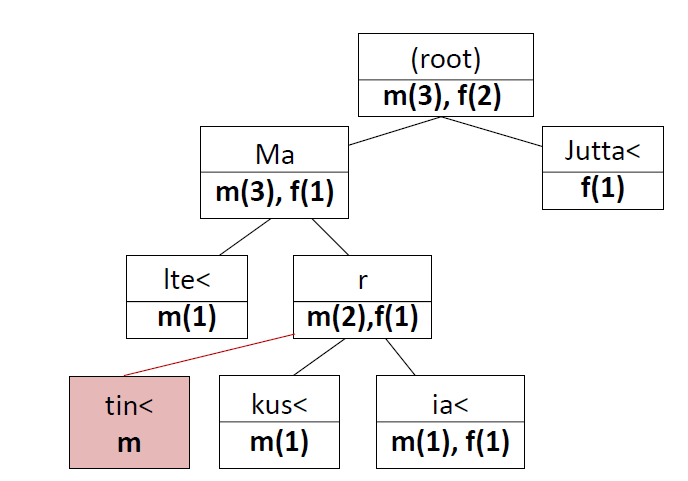

Distributional thesaurus is a word similarity graph (it connects semantically related words (nodes) with relations (edges). Each edge has a weight. It is very useful for such linguistics tasks as looking for the most similar words.

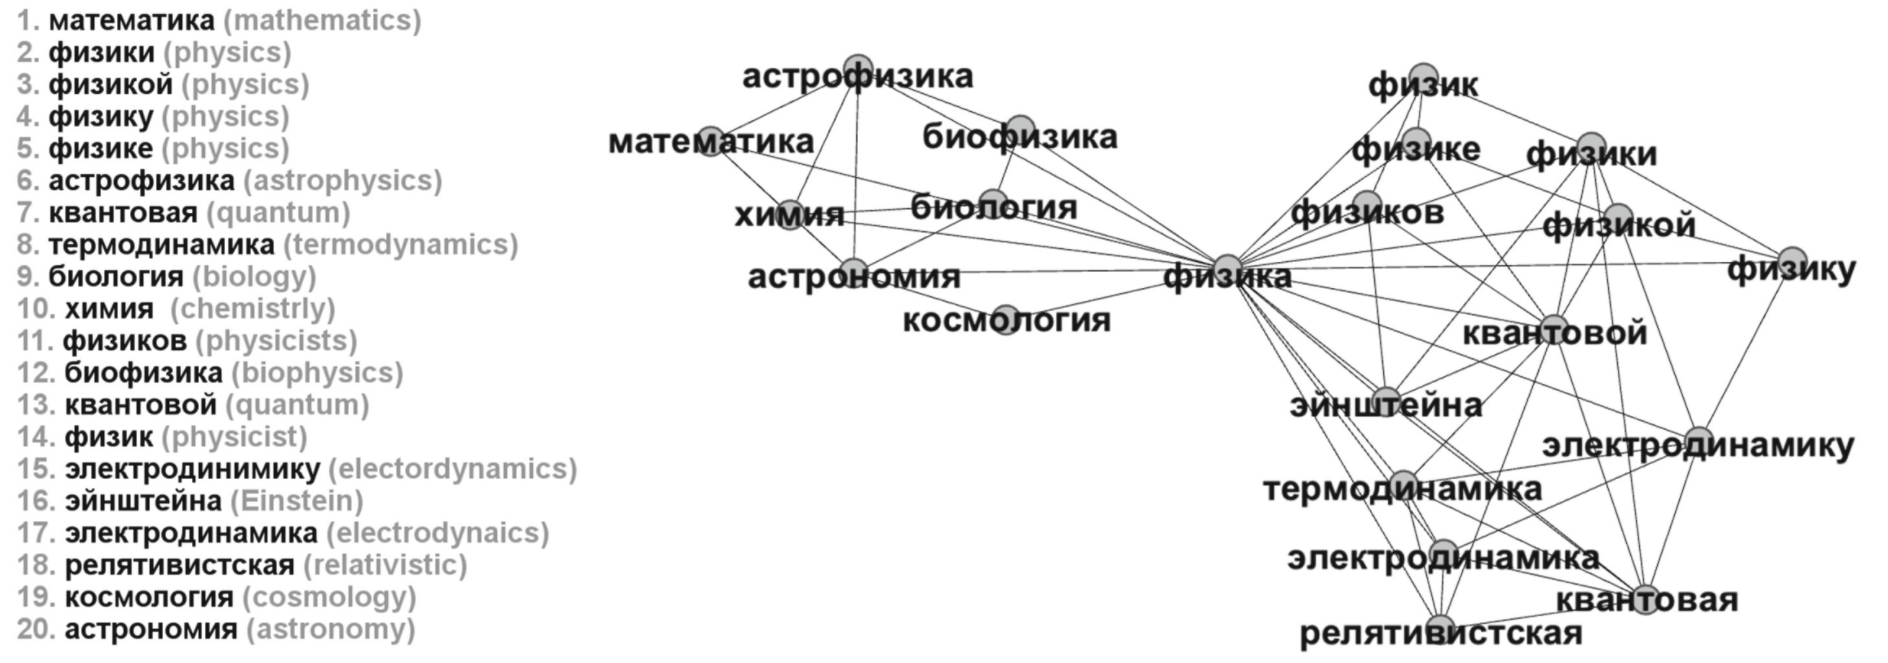



In both of the aforementioned examples the information can be stored in databse or in hash table. But database is not effective in case of high-load usage and hash table normally occupies much memory. The most effective way for storing distributaional thesaurus is implemented in [Russian Distributional Thesaurus github](https://github.com/nlpub/rdt). It stores graph in a more compact way by using Marisa Trie and numpy array. 

**Trie**, also called **digital tree or prefix tree**, is a kind of search tree—an ordered tree data structure used to store a dynamic set or associative array where the keys are usually strings. Each node position in the tree defines the key with which it is associated; i.e., the value of the key is distributed across the structure. All the descendants of a node have a common prefix of the string associated with that node, and the root is associated with the empty string.

In [ ]:
# Example of storing string-keys and corresponding values in hash table
{'to':7,
 'tea':3,
 'ted':4,
 'ten':12,
 'A':15,
 'i':11,
 'in':5,
 'inn':9}

{'A': 15, 'i': 11, 'in': 5, 'inn': 9, 'tea': 3, 'ted': 4, 'ten': 12, 'to': 7}

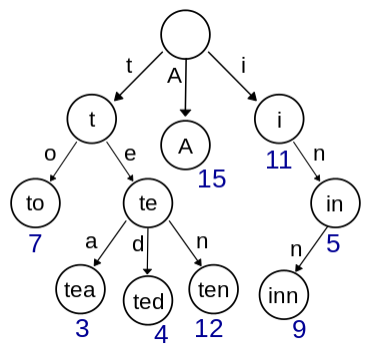

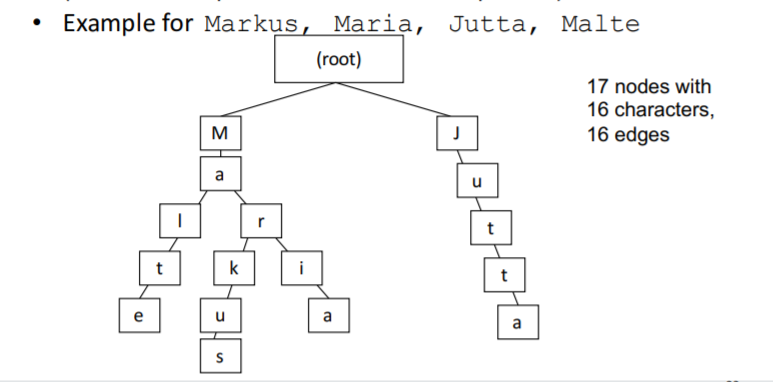

**Matching Algorithm with Recursively Implemented StorAge (MARISA)** is a static and space-efficient trie data structure.

A MARISA-based dictionary supports not only lookup but also reverse lookup, common prefix search and predictive search.

*   Lookup is to check whether or not a given string exists in a dictionary.
*   Reverse lookup is to restore a key from its ID.
*   Common prefix search is to find keys from prefixes of a given string.
*   Predictive search is to find keys starting with a given string.


**One string from distributional thesaurus**

словесность литература:0.693631, словесности:0.673393, поэзия:0.657318, литературу:0.646993, поэзию:0.625772, филология:0.623357, словесностью:0.614474, проза:0.610109, литературы:0.591108, литературная:0.583375, литератур:0.581673, литературоведение:0.581571, поэтику:0.576219, литтература:0.575055, прозу:0.571903, беллетристика:0.570541, книжность:0.567516, драматургия:0.565701, поэтика:0.565087, стихотворство:0.562407, публицистику:0.560926, публицистика:0.558548, журналистика:0.558000, допушкинскую:0.557183, поэзии:0.553815, литературные:0.552337, пиитику:0.550831, литературное:0.548529, допушкинской:0.547422, послепушкинская:0.545402, неотлучимы:0.545200, филологическая:0.542263, кребильйона:0.542140, реторической:0.541381, паралитературу:0.540992, своебытная:0.540851, риторика:0.540751, литературой:0.539374, пиитики:0.538791, бытописательскую:0.538671, витийственная:0.538429, пиитика:0.538293, японоязычная:0.537896, сентименталистская:0.536457, эстетика:0.536436, кантемиро:0.534982, эссеистика:0.534580, литературную:0.534455, преполнейший:0.534125, риторику:0.532908, философию:0.530697, литературных:0.530465, койпергейме:0.530071, литературной:0.529084, прозы:0.528637, допушкинское:0.528361, беллетристику:0.528068, философия:0.527975, художественная:0.527742, лингвопоэтика:0.527723, пиитике:0.526392, обэриутскую:0.525666, виршевой:0.525662, грамматика:0.525596


In case of storing distrubtional thesaurus we need to store word1 + \tab + word2 as a key. So we namely store each pair of words inside the trie, this lets us to assign unique value to each pair.

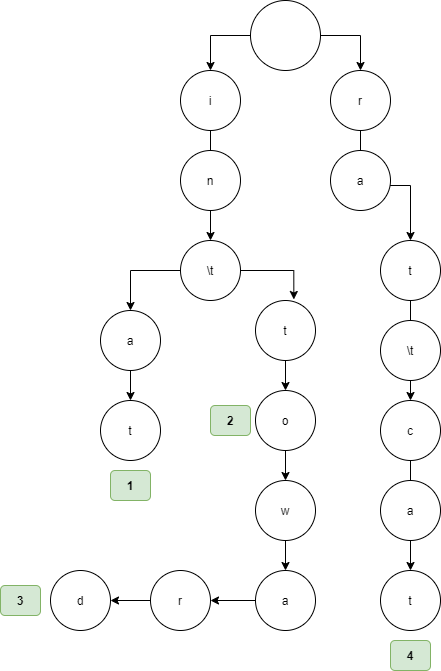

## 6.2.Baseline

In [ ]:
import gzip
from traceback import format_exc


SEP = "\t"
UNSEP = "_"
SEP_SCORE = ":"
SEP_LIST = ","
MIN_SIM = 0.0


In [ ]:
baseline_dict = {}
with gzip.open("/content/10k.txt.gz") as input_file:
  for i, line in enumerate(input_file):
      try:
          line = line.decode('utf-8')
          word_i, neighbors = line.split(SEP)
          word_i = word_i.replace(SEP, UNSEP)
          baseline_dict[word_i] = {}
          for word_j_sim_ij in neighbors.split(SEP_LIST):
              word_j, sim_ij = word_j_sim_ij.split(SEP_SCORE)
              word_j = word_j.replace(SEP, UNSEP)
              sim_ij = float(sim_ij)
              if sim_ij < MIN_SIM: continue
              baseline_dict[word_i][word_j] = sim_ij
              # print(word_i, word_j, sim_ij)
      except:
          print(format_exc())

In [ ]:
baseline_dict['и']

{'а': 0.803788,
 'аксару': 0.634477,
 'альтэрэго': 0.628554,
 'альцидой': 0.626077,
 'андхарского': 0.622163,
 'аннаполи': 0.632276,
 'арканориуме': 0.637013,
 'арканслата': 0.63515,
 'атвала': 0.654964,
 'ачела': 0.632354,
 'бифиттера': 0.628264,
 'больншой': 0.621354,
 'в': 0.722179,
 'вазос': 0.629251,
 'вейрун': 0.630851,
 'вилейнами': 0.621973,
 'вислицком': 0.634014,
 'вот': 0.620032,
 'все': 0.676077,
 'галлхиелом': 0.621864,
 'гархад': 0.626238,
 'гилсаларвин': 0.63278,
 'гирвиргуле': 0.622891,
 'гондской': 0.621532,
 'горенбургов': 0.630675,
 'даже': 0.700618,
 'диурнаху': 0.637284,
 'длившая': 0.623209,
 'долгоожидающая': 0.63773,
 'долгоотсутствующего': 0.622923,
 'доренков': 0.634001,
 'дорепрессионной': 0.636407,
 'драйды': 0.621377,
 'дуйко': 0.622821,
 'дьюржу': 0.64638,
 'его': 0.671647,
 'елисаветовка': 0.622072,
 'естественно': 0.622879,
 'еще': 0.689951,
 'же': 0.750797,
 'жужжей': 0.622793,
 'зарагуль': 0.622594,
 'затем': 0.626389,
 'зверохуй': 0.646926,
 'инфоархи

In [ ]:
baseline_dict['и']['а']

0.803788

## 6.3.Trie implementation

In [ ]:
import codecs
import gzip
import marisa_trie
import pickle as pickle
import urllib.error
import urllib.parse
import urllib.request
from heapq import heappop, heappush
from os import makedirs
from os.path import join, splitext, exists
from time import time
from traceback import format_exc

import numpy as np
from sklearn.externals import joblib

MIN_SIM = 0.0
KEYS = "keys.marisa"
SIMS = "sims"
VERBOSE = False
# RDT_FPATH = "rdt.pkl"
# RDT_URL = "http://panchenko.me/data/russe/rdt.pkl"
SEP = "\t"
UNSEP = "_"
SEP_SCORE = ":"
SEP_LIST = ","
MIN_SIM = 0.0

class DistributionalThesaurus:
    """ Represents a static distributional thesaurus, efficiently stored in memory. """

    def __init__(self, dt_dir):
        self.dt_dir = dt_dir

        self.keys_fpath = join(dt_dir, KEYS)
        self.sims_fpath = join(dt_dir, SIMS)

        if exists(self.keys_fpath) and exists(self.sims_fpath):
            print("Loading DT from:", dt_dir)
            self.load_dt(dt_dir)
        else:
            print("Cannot load DT from:", dt_dir)
            self.keys, self.sims = None, None

    def _iter_dt_word_word_score(self, dt_fpath):
        """ Iterates over a 'word_i<TAB>word_j<TAB>sim_ij' file,
        yielding (word_i, word_j, sim_ij) tuples. """
        with gzip.open(dt_fpath) if splitext(dt_fpath)[-1] == ".gz" else codecs.open(dt_fpath, "r",
                                                                                     "utf-8") as input_file:
            rel_num = 0
            for i, line in enumerate(input_file):
                try:
                    fields = line.split(SEP)
                    if len(fields) != 3: continue
                    sim = float(fields[2])
                    if sim < MIN_SIM: continue
                    rel_num += 1
                    word_i = fields[0].replace(SEP, UNSEP)
                    word_j = fields[1].replace(SEP, UNSEP)
                    yield (word_i, word_j, sim)
                except:
                    print(format_exc())
                    if VERBOSE: print("bad line:", i, line)
 
            print("# relations loaded:", rel_num, "out of", i + 1)

    def _iter_dt_word_neighbors(self, dt_fpath):
        """ Iterates over a 'word_i<TAB>word_i:sim_ij,word_k:sim_ik'
        file, yielding (word_i, word_j, sim_ij) tuples. """

        with gzip.open(dt_fpath) if splitext(dt_fpath)[-1] == ".gz" else codecs.open(dt_fpath, "r", "utf-8") as input_file:
            rel_num = 0
            for i, line in enumerate(input_file):
                try:
                    word_i, neighbors = line.split(SEP)
                    word_i = word_i.replace(SEP, UNSEP)
                    # print("word_i", word_i)
                    for word_j_sim_ij in neighbors.split(SEP_LIST):
                        word_j, sim_ij = word_j_sim_ij.split(SEP_SCORE)
                        word_j = word_j.replace(SEP, UNSEP)
                        sim_ij = float(sim_ij)
                        if sim_ij < MIN_SIM: continue
                        rel_num += 1
                        # print(word_i, word_j, sim_ij)
                        yield word_i, word_j, sim_ij
                except:
                    print(format_exc())
                    if VERBOSE: print("bad line:", i, line)

            print("# relations loaded:", rel_num)
            print("# lines processed:", i + 1)

    def build_dt(self, dt_fpath, dt_format="word_neighbors",):
        """ Builds and persists data structures for storage of DT:
        a marisa trie for keys + a numpy array for scores. 
        The 'dt_format' is in 'word_word_score', 'word_neighbors'. 
        word_word_score corresponds to a CSV file 'word_i<TAB>word_j<TAB>sim_ij'.
        word_neighbors corresponds to a CSV file 'word_i<TAB>word_j:sim_ij,work_k:sim_ik,...'
        """

        tic = time()
        if dt_format == "word_word_score":
            iter_dt = self._iter_dt_word_word_score
        elif dt_format == "word_neighbors":
            iter_dt = self._iter_dt_word_neighbors
        else:
            iter_dt = self._iter_dt_word_word_score

        if not exists(self.dt_dir): makedirs(self.dt_dir)
        print("loading to self.keys (marisa_trie.Trie )... ")
        self.keys = marisa_trie.Trie([w1 + SEP + w2 for w1, w2, _ in iter_dt(dt_fpath)])
        self.keys.save(self.keys_fpath)
        print("DT keys:", self.keys_fpath)

        self.sims = np.zeros(len(self.keys), dtype='Float16')
        print("loading to self.sims (numpy array) ... ")
        for i, (w1, w2, sim) in enumerate(iter_dt(dt_fpath)):
            unique_pair_value_from_trie = self.keys.key_id(w1 + SEP + w2)
            self.sims[unique_pair_value_from_trie] = sim 
        # sims will look like [0.68   0.7256 0.6484 0.645  0.734 .... ] 
        # self.keys.key_id(w1 + SEP + w2) gives us unique vaue of word pair stored inside tries
        #for example pair w1 = 'in' and w2 = 'at' has unique value 1 inside tire, whch means that  self.keys.key_id(w1 + SEP + w2) == 1
        # in this case if we want to learn coocurency value of word 'in' and word 'at' we will need to look at the element self.sims[1]
        print("sims",self.sims[:15])
        print("finished")
        joblib.dump(self.sims, self.sims_fpath)
        print("DT scores:", self.sims_fpath)
        print("Building DT took", time() - tic, "sec.")

    def load_dt(self, input_dir):
        """ Loads a pre-built distributional thesaurus structure. """

        tic = time()
        self.keys = marisa_trie.Trie()
        self.keys.load(self.keys_fpath)
        print("Loaded %d keys: %s" % (len(list(self.keys.items())), self.keys_fpath))
        self.sims = joblib.load(self.sims_fpath)
        print("Loaded %d scores: %s" % (self.sims.size, self.sims_fpath))
        print("Loading DT took", time() - tic, "sec.")

    def most_similar(self, word_i, top_n=20):
        """ Get most similar terms of a word from the distributional thesaurus. """

        if self.keys is None or self.sims is None:
            print("Model is not loaded: load or build a DT first.")
            return []
        # using heappush/heappop to sort by score
        h = []
        for word_i_sep_word_j in self.keys.keys(word_i + SEP):#iterate over each pair of the 'word' stord inside the keys structure
            unique_pair_index = self.keys[word_i_sep_word_j]
            pair_similarity_value = self.sims[unique_pair_index]
            pair_similarity_value = -1 * pair_similarity_value#multiply by minus for further usage of heappop func which pops and returns the smallest item
            heappush(h, (pair_similarity_value, word_i_sep_word_j))

        res = [heappop(h) for i in range(len(h))]
        res = [(pair.split(SEP)[-1], -sim) for sim, pair in res]
        return res[:top_n]

## 6.4.Inference

In [ ]:
rdt = DistributionalThesaurus(dt_dir="/test_folder")

Loading DT from: /test_folder
Loaded 1859678 keys: /test_folder/keys.marisa
Loaded 1859678 scores: /test_folder/sims
Loading DT took 2.8767237663269043 sec.


In [ ]:
# !gzip -d /content/10k.txt.gz 

In [ ]:
rdt_path = "/content/10k.txt"
rdt.build_dt(dt_fpath = rdt_path, dt_format="word_neighbors")

loading to self.keys (marisa_trie.Trie )... 
# relations loaded: 1859678
# lines processed: 10000
DT keys: /test_folder/keys.marisa
loading to self.sims (numpy array) ... 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:115: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


# relations loaded: 1859678
# lines processed: 10000
sims [0.68   0.7256 0.6484 0.645  0.734  0.6367 0.6953 0.7686 0.655  0.72
 0.6567 0.6484 0.6846 0.646  0.67  ]
finished
DT scores: /test_folder/sims
Building DT took 14.783653974533081 sec.


In [ ]:
for w,s in rdt.most_similar("мама"):
    print(w,s)

бабушка 0.83349609375
мамочка 0.80859375
маме 0.8017578125
мамой 0.78955078125
тетя 0.78759765625
маму 0.76904296875
мамы 0.76708984375
папа 0.72119140625
мать 0.7197265625
патошки 0.7060546875
фьютифьютик 0.7041015625
мамапапа 0.69677734375
мамуля 0.6943359375
бабушкой 0.69384765625
катрусиной 0.689453125
асютка 0.6884765625
паукертова 0.6865234375
доченька 0.6826171875
девочка 0.681640625
абдугани 0.68115234375


## 6.5.Memory consumption comparison (with 10k samples)

15 times more effective from the memory point of view 

|             |Resourses  |
|-------------|----------------------------|
| Baseline    | 300Mb                      |
| MARISA trie | 20Mb                       |

# 7.Rule-based information extraction

There are several rule based grammar packages, which can also help in information extraction task

Here are some basic examples

*   [Yargi](https://github.com/natasha/yargy) ([here](https://www.youtube.com/watch?v=NQxzx0qYgK8)  and [here](https://github.com/natasha/yargy-examples/blob/master/04_food/workshop.ipynb) you can find some tutorials)
*   [Tomita](https://github.com/yandex/tomita-parser)


Pros:
1. Decent tool for Russin language
2. Has  many options to deal with grammar
3. Fast to implement
4. Could use ML tags
5. It has Natasha inside


Cons:

1. Slow
2. It's best to work with standardized text

## 7.1.Documentation
1. http://reports-archive.adm.cs.cmu.edu/anon/anon/usr/ftp/scan/CMU-CS-68-earley.pdf
2. https://github.com/natasha/yargy

3. https://notebook.community/bureaucratic-labs/yargy/docs/index

## Installation

## 7.2.Imports

In [ ]:
from yargy import Parser, rule, and_, not_, or_
from yargy.pipelines import morph_pipeline, pipeline
from yargy.interpretation import fact, attribute
from yargy.predicates import gram, normalized, eq, tag, dictionary, type, caseless, in_, gte,lte,custom,  is_capitalized, dictionary, tag
from yargy.tagger import Tagger
from yargy.relations import gnc_relation
from yargy.tokenizer import MorphTokenizer, EOL

**Example 1. Token and its features**

Forms
1. Part of speech
2. Case 
3. Animacy 
4. Gender
5. Number

In [ ]:
example = '''Ритмы синусовые, регулярный...'''

tokenizer = MorphTokenizer()

for token in list(tokenizer(example)):
  print (token.value, token)

Ритмы MorphToken(value='Ритмы', span=[0, 5), type='RU', forms=[Form('ритм', Grams(NOUN,inan,masc,nomn,plur)), Form('ритм', Grams(NOUN,accs,inan,masc,plur))])
синусовые MorphToken(value='синусовые', span=[6, 15), type='RU', forms=[Form('синусовый', Grams(ADJF,nomn,plur)), Form('синусовый', Grams(ADJF,accs,inan,plur))])
, Token(value=',', span=[15, 16), type='PUNCT')
регулярный MorphToken(value='регулярный', span=[17, 27), type='RU', forms=[Form('регулярный', Grams(ADJF,Qual,masc,nomn,sing)), Form('регулярный', Grams(ADJF,Qual,accs,inan,masc,sing))])
. Token(value='.', span=[27, 28), type='PUNCT')
. Token(value='.', span=[28, 29), type='PUNCT')
. Token(value='.', span=[29, 30), type='PUNCT')


## 7.3.Rules
It's possible to use 
1. Tokens
2. Grams
3. Tags
4. Predicates
5. Interpretations 

**Example 2. Predicate based rule for a single token**

Yargy has quite unusual but still very useful rules syntax

In [ ]:
token = next(tokenizer('Aспирин'))

predicate = and_(
    is_capitalized(),
    not_(eq('Синкумар'))
)

assert predicate(token) == True


**Examples 3-8. Token based rules for a text** 

We may look for the sequence of normalized tokens, but we should remember that yargy does not handle misspelling.

In [ ]:
rule_sin_full = rule(
    normalized("Ритм"),
    normalized("синусовый")
)

In [ ]:
text = '''ЭКГ (09.01.2089): Ритмы синусовые, регулярный. ЧСС 77 уд. в минуту.
Нормальное положение электрической оси сердца. Промежуточная позиция сердца. '''

parser = Parser(rule_sin_full)
matches = list(parser.findall(str(text)))
matches

[Match(
     tokens=[MorphToken(
          value='Ритмы',
          span=[18, 23),
          type='RU',
          forms=[Form('ритм', Grams(NOUN,inan,masc,nomn,plur)),
           Form('ритм', Grams(NOUN,accs,inan,masc,plur))]
      ),
      MorphToken(
          value='синусовые',
          span=[24, 33),
          type='RU',
          forms=[Form('синусовый', Grams(ADJF,nomn,plur)),
           Form('синусовый', Grams(ADJF,accs,inan,plur))]
      )],
     span=[18, 33)
 )]

Similarly to standard regexp logic we may look for some tokens but set them as non-obligatory or optional

In [ ]:
rule_tric_reg = rule(
            normalized("регургитация"),
            normalized("I").optional(),
            dictionary(["степени", "ст", "степ"]).optional(),
        )

text = 'трикуспидальные регургитация 2 ст'

parser = Parser(rule_tric_reg)
matches = list(parser.findall(str(text)))
matches

[Match(
     tokens=[MorphToken(
          value='регургитация',
          span=[16, 28),
          type='RU',
          forms=[Form('регургитация', Grams(NOUN,femn,inan,nomn,sing))]
      )],
     span=[16, 28)
 )]

We may also look for the sequence which has everything but definite normalized token in its beginning

In [ ]:
example_1 = "У пациента наблюдался начальный атеросклероз"
example_2 = "У пациента наблюдался атеросклероз"
example_3 = "Атеросклероз у пациента наблюдался на диагностике"
example_set = [example_1, example_2, example_3]

rule_not_sin = rule(
    not_(normalized('начальный')),
    normalized('атеросклероз')
)
for example in example_set:
  parser = Parser(rule_not_sin)
  matches = list(parser.findall(str(example)))
  for match in matches:
    print([_.value for _ in match.tokens], str(example))

['наблюдался', 'атеросклероз'] У пациента наблюдался атеросклероз


It is also possible to use a morhologically preprocessed seqeunce as a rule

In [ ]:
text = 'начальный атеросклероз артерий нижних конечностей'
rule_pos = morph_pipeline(['атеросклероз артерий нижних конечностей'])
rule_neg = morph_pipeline(['начальный атеросклероз артерий нижних конечностей'])
parser = Parser(rule_pos)
matches = list(parser.findall(str(text)))
print(len(matches))

parser = Parser(rule_neg)
matches2 = list(parser.findall(str(text)))
print(len(matches2))

1
1


Such morphological preprocessing for rule creation may sometimes be easier than making a batch of complex rules.

In [ ]:
# Option 1 - complex rules
rule_stroke_1 = rule(
      dictionary(["инсульт", "ОНМК", "ИИ", "НМК"])
 )
rule_stroke_2 =  rule(
      normalized('ишемический'),
      normalized('инсульт')
 )


rule_stroke_complex  = rule(
    or_(rule_stroke_1,
        rule_stroke_2)
)
 
#Option 2 - morpholgically preprocessed sequences used as a rule
rule_stroke = morph_pipeline('инсульт, ОНМК, ИИ, ишемический инсульт, НМК, постинсультная киста, постинсультные кисты, последствия ишемического инсульта, \
                            последствия ОНМК, последствия перенесенного ишемического инсульта, последствия перенесенного инсульта, \
                            инфаркт головного мозга, инфаркт ГМ'.split(','))
 
example_1 = "У пациента зафиксирован ОНМК"
example_2 = "У пациента наблюдался атеросклероз"
example_3 = "последствия перенесенного инсульта зафиксированы 29.12.2088"
example_set = [example_1, example_2, example_3]


for example in example_set:
  parser = Parser(rule_stroke)
  matches = list(parser.findall(str(example)))
  for match in matches:
    print([_.value for _ in match.tokens], str(example))

['ОНМК'] У пациента зафиксирован ОНМК
['последствия', 'перенесенного', 'инсульта'] последствия перенесенного инсульта зафиксированы 29.12.2088


## 7.4.Part of Speech based rules
https://notebook.community/bureaucratic-labs/yargy/docs/index

Specifying POS information withn your rule could be very useful. Let's have a look at the  example

In [ ]:
GEO = rule(
    and_(
        gram('ADJF'),  
                       # http://pymorphy2.readthedocs.io/en/latest/user/grammemes.html
        is_capitalized()
    ),
    gram('ADJF').optional().repeatable(),
    dictionary({
        'федерация',
        'республика'
    })
)

parser = Parser(GEO)
text = '''
В Чеченской республике на день рождения ...
Африканская республика провозгласила ...
Башня Федерация — одна из самых высоких ...
Вот же многострадальная республика'''
for match in parser.findall(text):
    print([_.value for _ in match.tokens])

NameError: ignored

## 7.5. Create logical structure of your match

We can not only look for some mathces, but also create a structured logical representatio of the entity.

Let's consider an example in which we want to parse a date

In [ ]:
Date = fact(
    'Date',
    ['year', 'month', 'day']
)

DAY = and_(
    gte(1),
    lte(31)
).interpretation(
    Date.day
)

MONTH = and_(
    gte(1),
    lte(12)
).interpretation(
    Date.month
)

YEAR = and_(
    gte(1),
    lte(2100)
).interpretation(
    Date.year
)

MONTHS = {
    'январь': 1,
    'февраль': 2,
    'март': 3,
    'апрель': 4,
    'май': 5,
    'июнь': 6,
    'июль': 7,
    'август': 8,
    'сентябрь': 9,
    'октябрь': 10,
    'ноябрь': 11,
    'декабрь': 12
}

MONTH_NAME = dictionary(
    MONTHS
).interpretation(
    Date.month
)

YEAR_WORDS = or_(
    rule(caseless('г'), '.'),
    rule(normalized('год'))
)

DATE = or_(
    rule(YEAR, '-', MONTH, '-', DAY),
    rule(
        DAY,
        MONTH_NAME,
        YEAR,
        YEAR_WORDS.optional()
    )
).interpretation(Date)

parser = Parser(DATE)
match = parser.match('05 февраля 2011 года')
print(match)
print(match.fact)

Match(tokens=[Token(value='05', span=[0, 2), type='INT'), MorphToken(value='февраля', span=[3, 10), type='RU', forms=[Form('февраль', Grams(NOUN,gent,inan,masc,sing))]), Token(value='2011', span=[11, 15), type='INT'), MorphToken(value='года', span=[16, 20), type='RU', forms=[Form('год', Grams(NOUN,gent,inan,masc,sing)), Form('год', Grams(Infr,NOUN,accs,inan,masc,plur)), Form('год', Grams(Infr,NOUN,inan,masc,nomn,plur))])], span=[0, 20))
Date(year='2011', month='февраля', day='05')


The match has not only the information about position of words and their morphological properties within spans, but also forms a pre-defined structure which can be vizualized like that

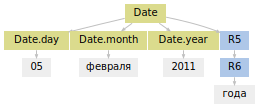

In [ ]:
match.tree.as_dot

Let's gain even more intuition with the example of collecting infromation about a person

In [ ]:
Name = fact(
    'Name',
    ['first', 'last'],
)
Person = fact(
    'Person',
    ['position', 'name']
)

LAST = and_(
    gram('Surn'),
    not_(gram('Abbr')),
)
FIRST = and_(
    gram('Name'),
    not_(gram('Abbr')),
)

POSITION = morph_pipeline([
    'управляющий директор',
    'вице-мэр'
])

gnc = gnc_relation()
NAME = rule(
    FIRST.interpretation(
        Name.first
    ).match(gnc),
    LAST.interpretation(
        Name.last
    ).match(gnc)
).interpretation(
    Name
)

PERSON = rule(
    POSITION.interpretation(
        Person.position
    ).match(gnc),
    NAME.interpretation(
        Person.name
    )
).interpretation(
    Person
)

parser = Parser(PERSON)

match = parser.match('управляющий директор Иван Ульянов')
print(match)

Match(tokens=[MorphToken(value='управляющий', span=[0, 11), type='RU', forms=[Form('управлять', Grams(PRTF,Subx,actv,impf,intr,masc,nomn,pres,sing))]), MorphToken(value='директор', span=[12, 20), type='RU', forms=[Form('директор', Grams(NOUN,anim,masc,nomn,sing))]), MorphToken(value='Иван', span=[21, 25), type='RU', forms=[Form('иван', Grams(NOUN,Name,anim,masc,nomn,sing))]), MorphToken(value='Ульянов', span=[26, 33), type='RU', forms=[Form('ульянов', Grams(NOUN,Sgtm,Surn,anim,masc,nomn,sing))])], span=[0, 33))


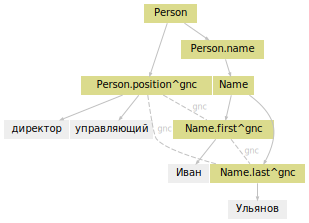

In [ ]:
match.tree.as_dot

## 7.6.More examples

https://github.com/natasha/yargy-examples/blob/master/01_resume/notes.ipynb

https://github.com/natasha/yargy/blob/master/docs/cookbook.ipynb

https://habr.com/ru/post/349864/
